In [1]:
source("/secure/projects/HTAPP_MBC/src/init_phase2.R")

Registered S3 method overwritten by 'R.oo':
  method        from       
  throw.default R.methodsS3
Loading combined annotation: annot


In [2]:
setwd(paste0(spatialDir,"/01_typing/combined_all/"))

In [3]:
combined=fread(paste0("all_methods_obs.tsv"))

In [4]:
scsn=fread(paste0(baseDir,"/PyCache/fresh_frozen_combined_obs.tsv"))
scsn=scsn[name%in%combined$sample]

In [5]:
ct_counts=combined[,.(ct_count=.N),by=c("sample","replicate","method","bin_100","x_100","y_100","OT")]

In [6]:
pre_expand=unique(ct_counts[,c("sample","bin_100","OT","replicate","method")])
expand=pre_expand[,expand.grid(bin_100=unique(bin_100),OT=unique(OT)),by=c("sample","replicate","method")]

In [7]:
ct_counts=merge(ct_counts,expand,by=c("sample","bin_100","OT","replicate","method"),all = TRUE)

In [8]:
ct_counts[,c("x_100","y_100"):=list(unique(x_100[!is.na(x_100)]),unique(y_100[!is.na(y_100)])),by=c("sample","bin_100")]
ct_counts[,ct_count:=ifelse(is.na(ct_count),0,ct_count),]

In [9]:
ct_counts[,ct_frac:=ct_count/sum(ct_count),by=c("sample","replicate","method","bin_100","x_100","y_100")]

### Calculate correaltions

In [9]:
get_cors=function(sub){
    mat=dcast(sub,method+replicate~OT,value.var = "ct_frac",fill = 0)
    mat[,rn:=paste0(method,"_",replicate),]
    df=data.frame(mat[,-c("method","replicate")],row.names = "rn")
    if (nrow(df)<2){
        return()
    }
    cors=cor(t(df))
    cors[lower.tri(cors,diag = TRUE)]<-NA
    res=as.data.table(reshape2::melt(cors))
    res=res[!is.na(value),]
    return(res)
}

In [10]:
all_cors=ct_counts[,get_cors(.SD),by=c("sample","bin_100","x_100","y_100")]

In [60]:
all_cors[,method1:=sub("_[0-9]","",Var1),]
all_cors[,method2:=sub("_[0-9]","",Var2),]
all_cors[,method:=paste0(method1,"|",method2),]
all_cors[,mean:=mean(value),by=method]
all_cors[,method:=factor(method,levels=unique(method[order(mean)])),]

In [14]:
pl=ggplot(all_cors,aes(x=x_100,y=y_100,col=value))+geom_point(size=1)+facet_grid(sample~Var1+Var2)+
    scale_color_gradient2(low="blue",mid="grey95",high="red")+coord_fixed()
pdf("ct_correlations_space.pdf",width=250,height=150)   
print(pl)
dev.off()
options(repr.plot.width = 200, repr.plot.height =100)
pl

png 
  2

png 
  2

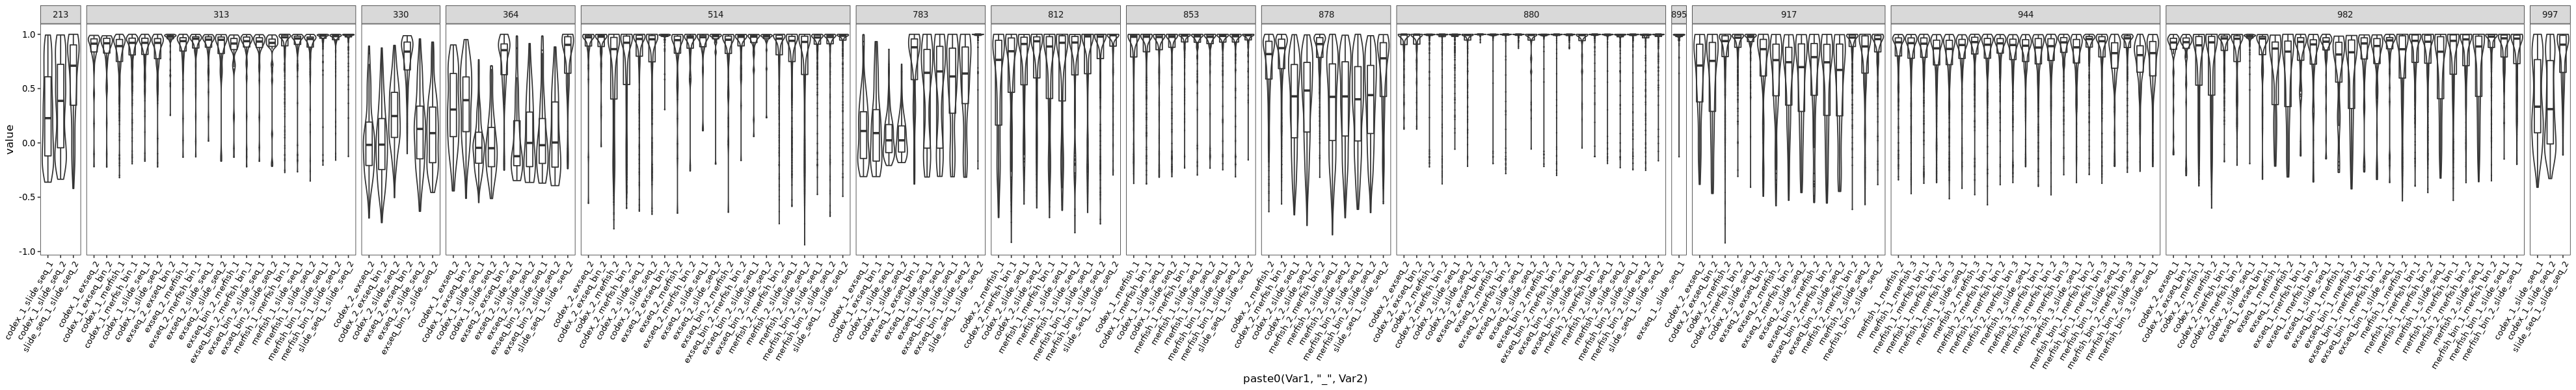

In [62]:
options(repr.plot.width = 33, repr.plot.height =5)
pl=ggplot(all_cors,aes(x=paste0(Var1,"_",Var2),y=value))+geom_violin(scale = "width")+
geom_boxplot(,width=0.5,outlier.size = 0,fill="transparent")+
facet_grid(~gsub("HTAPP-|-SMP-.*","",sample),scale="free_x",space="free")+rotate_labels()
pdf("ct_cors.pdf",height=5,width=33)
pl
dev.off()
pl

Warning message in min(x):
"no non-missing arguments to min; returning Inf"Warning message in max(x):
"no non-missing arguments to max; returning -Inf"Warning message in min(x):
"no non-missing arguments to min; returning Inf"Warning message in max(x):
"no non-missing arguments to max; returning -Inf"

png 
  2

Warning message in min(x):
"no non-missing arguments to min; returning Inf"Warning message in max(x):
"no non-missing arguments to max; returning -Inf"Warning message in min(x):
"no non-missing arguments to min; returning Inf"Warning message in max(x):
"no non-missing arguments to max; returning -Inf"

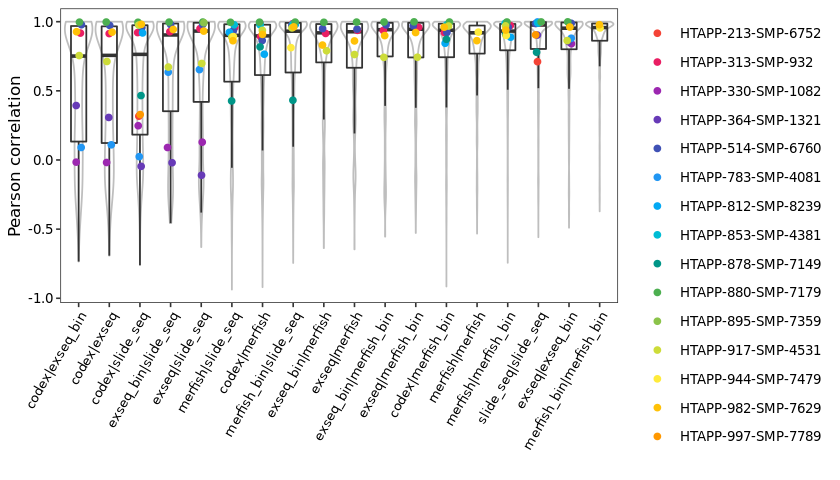

In [76]:
options(repr.plot.width = 7, repr.plot.height =4)
pl=ggplot(all_cors,aes(x=method,y=value))+geom_violin(scale = "width",color="grey")+
geom_boxplot(width=0.5,outlier.shape = NA,fill="transparent")+
stat_summary(geom = "point", fun.y = "median",size=1.5,aes(col = sample), position=position_jitter(width=0.1))+
rotate_labels()+ylab("Pearson correlation")+xlab("")+theme(,legend.spacing.y = unit(3, 'cm'))+
scale_color_manual(values=c('#F44336','#E91E63','#9C27B0','#673AB7','#3F51B5',
                                            '#2196F3','#03A9F4','#00BCD4','#009688','#4CAF50',
                                            '#8BC34A','#CDDC39','#FFEB3B','#FFC107','#FF9800'))
pdf("ct_cors_summarized.pdf",height=4,width=7)
pl
dev.off()
pl

### Cell type composion comparison per sample

In [18]:
st_ot=combined[,.(counts=.N),by=c("sample","method","OT")]
st_rctd=combined[,.(counts=.N),by=c("sample","method","RCTD")]
scsn_ct=scsn[,.(counts=.N),by=c("name","condition","cell_type")]

In [19]:
st_ot[,ct_frac:=counts/sum(counts),by=c("sample","method")]
st_rctd[,ct_frac:=counts/sum(counts),by=c("sample","method")]
scsn_ct[,ct_frac:=counts/sum(counts),by="name"]

In [20]:
all_ct_frag=merge(st_ot,st_rctd,by.x = c('sample','method','OT'),by.y = c('sample','method','RCTD'),suffixes = c("OT","RCTD"))
all_ct_frag=merge(all_ct_frag,scsn_ct,by.x = c('sample','OT'),by.y = c('name','cell_type'))

In [21]:
head(all_ct_frag)

sample             OT                   method    countsOT ct_fracOT 
1 HTAPP-213-SMP-6752 Endothelial_vascular codex     3340     0.12516395
2 HTAPP-213-SMP-6752 Endothelial_vascular slide_seq  158     0.01687674
3 HTAPP-213-SMP-6752 Fibroblast           codex     4356     0.16323777
4 HTAPP-213-SMP-6752 Fibroblast           slide_seq 2208     0.23584704
5 HTAPP-213-SMP-6752 MBC                  codex     9199     0.34472550
6 HTAPP-213-SMP-6752 MBC                  slide_seq 4540     0.48493912
  countsRCTD ct_fracRCTD condition counts ct_frac   
1   380      0.01424021  TST        628   0.06408817
2   200      0.02136296  TST        628   0.06408817
3 19061      0.71429642  TST       1525   0.15562813
4  1298      0.13864559  TST       1525   0.15562813
5   565      0.02117294  TST       3426   0.34962751
6  5183      0.55362102  TST       3426   0.34962751

In [27]:
cors_sample=all_ct_frag[,.(cor_OT=cor(ct_fracOT,ct_frac),cor_RCTD=cor(ct_fracRCTD,ct_frac)),by=c("sample","method","condition")]
cors_sample=melt(cors_sample,id.vars = c("sample","method","condition"))

png 
  2

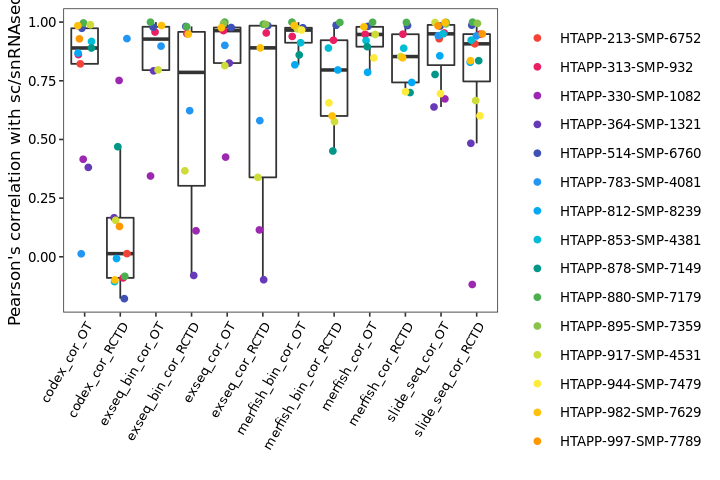

In [28]:
options(repr.plot.width = 6, repr.plot.height =4)
pl=ggplot(cors_sample,aes(x=paste0(method,'_',variable),y=value))+geom_boxplot(outlier.size = -1)+
geom_point(position=position_jitter(width=0.2),aes(col=sample))+
scale_color_manual(values=c('#F44336','#E91E63','#9C27B0','#673AB7','#3F51B5',
                                            '#2196F3','#03A9F4','#00BCD4','#009688','#4CAF50',
                                            '#8BC34A','#CDDC39','#FFEB3B','#FFC107','#FF9800'))+
rotate_labels()+theme(,legend.spacing.y = unit(3, 'cm'))+ylab("Pearson's correlation with sc/snRNAseq")+xlab("")

pdf("ct_cors_snsc_annot.pdf",height=4,width=6)
pl
dev.off()
pl

png 
  2

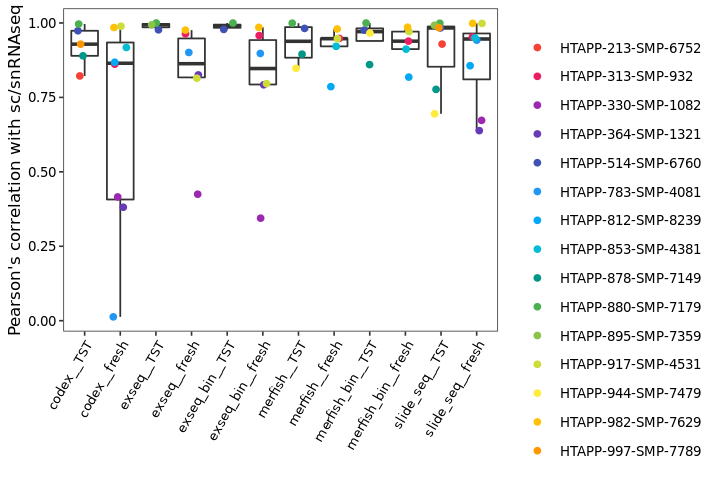

In [29]:
options(repr.plot.width = 6, repr.plot.height =4)
pl=ggplot(cors_sample[variable=="cor_OT"],aes(x=paste0(method,'__',condition),y=value))+geom_boxplot(outlier.size = -1)+
geom_point(position=position_jitter(width=0.2),aes(col=sample))+
scale_color_manual(values=c('#F44336','#E91E63','#9C27B0','#673AB7','#3F51B5',
                                            '#2196F3','#03A9F4','#00BCD4','#009688','#4CAF50',
                                            '#8BC34A','#CDDC39','#FFEB3B','#FFC107','#FF9800'))+
rotate_labels()+theme(,legend.spacing.y = unit(3, 'cm'))+ylab("Pearson's correlation with sc/snRNAseq")+xlab("")

pdf("ct_cors_snsc_condition.pdf",height=4,width=6)
pl
dev.off()
pl

### Bin characterization

In [46]:
head(compartment_counts)

sample             bin_100 replicate method x_100 y_100 compartment
1 HTAPP-213-SMP-6752 32      1         codex  10    37    Stromal    
2 HTAPP-213-SMP-6752 32      1         codex  10    37    Myeloid    
3 HTAPP-213-SMP-6752 32      1         codex  10    37    Malignant  
4 HTAPP-213-SMP-6752 32      1         codex  10    37    T/NK       
5 HTAPP-213-SMP-6752 46      1         codex  10    39    Stromal    
6 HTAPP-213-SMP-6752 46      1         codex  10    39    Myeloid    
  compartment_count compartment_frac
1  4                0.1428571       
2  5                0.1785714       
3 19                0.6785714       
4  0                0.0000000       
5 11                0.1506849       
6  8                0.1095890

In [40]:
ct_counts[,compartment:=ifelse(grepl("MBC",OT),"Malignant",ifelse(OT%in%c("T","NK"),"T/NK",ifelse(OT%in%c("Monocyte","Macrophage","Mast"),"Myeloid",ifelse(OT%in%c("B","B_Plasma"),"B","Stromal")))),]

In [43]:
compartment_counts=ct_counts[,.(compartment_count=sum(ct_count)),by=c("sample","bin_100","replicate","method","x_100","y_100","compartment")]

In [45]:
compartment_counts[,compartment_frac:=compartment_count/sum(compartment_count),by=c("sample","bin_100","replicate","method","x_100","y_100")]

In [69]:
compartment_mix=compartment_counts[,.(MalTNK=compartment_frac[compartment=="Malignant"]>0.4&compartment_frac[compartment=="T/NK"]>0.01),by=c("sample","bin_100","replicate","method","x_100","y_100")]

In [70]:
table(compartment_mix$MalTNK)


FALSE  TRUE 
16744  6325 

In [71]:
bin_fractions=compartment_mix[,.(MalTNK=sum(MalTNK)/.N),by=c("sample","replicate","method")]

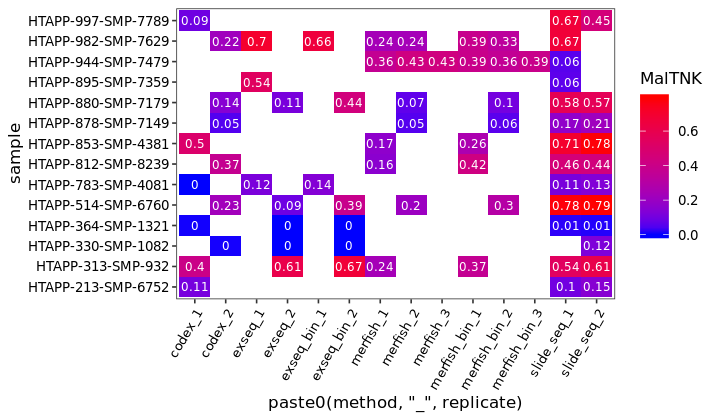

In [83]:
options(repr.plot.width = 6, repr.plot.height =3.5)
ggplot(bin_fractions,aes(x=paste0(method,"_",replicate),y=sample,fill=MalTNK))+geom_tile()+geom_text(aes(label=round(MalTNK,2)),size=2.5,color="white")+scale_fill_gradient(low="blue",high="red")+rotate_labels()